In [38]:
import ast

import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from shapely.geometry import LineString
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shapely.wkt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mplc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


#import shap


import scipy.stats
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text

from pathlib import Path

In [39]:
cwd = Path.cwd()
parent_dir = cwd.parent.parent

parent_dir

PosixPath('/home/veror/Desktop/Tweet2Geo/NEW Tweet2Geo')

### methods

In [40]:
def linear_regplot(x,y,confidence=0.95):
    # function modified by me to fit my data

    xs = np.array([x_ for x_, _ in sorted(zip(x, y))])
    ys = np.array([y_ for _, y_ in sorted(zip(x, y))])

    X = sm.add_constant(xs)
    res = sm.OLS(ys, X).fit()

    st, data, ss2 = summary_table(res, alpha=1-confidence)
    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    predict_ci_low, predict_ci_upp = data[:,6:8].T

    y_fit  = 10**(fittedvalues)
    y_low  = 10**predict_mean_ci_low
    y_high = 10**predict_mean_ci_upp
    stats  = {'intercept':res.params[0], 'slope': res.params[1], 'R2':res.rsquared}
    print('slope', stats['slope'])
    print('intercept', stats['intercept'])

    return xs, ys, y_fit, y_low, y_high, stats

### main

In [42]:
AREA = 'EU'
AREA_PATHS = {'EU':parent_dir / 'Data' / 'Europe' / 'flux_info_2.csv',
              'SA':parent_dir / 'Data' / 'South America' / 'SA info.csv',
              'US':parent_dir / 'Data' / 'US' / 'US info no wa.csv'}

def process_df(AREA_PATHS, AREA):

    df = pd.read_csv(AREA_PATHS[AREA])

    if AREA == 'EU':
        '''df['GDP_2022_billions'] = df['GDP_2022']
        df['GDP_2022'] = df.apply(lambda row: int(row['GDP_2022_billions']*1000000000), axis = 1)

        df['gdp per capita'] = df['GDP_2022'] / df['POP_EST']
        df['tweets per day per person'] = df['# tweets/day'] / df['POP_EST']'''

        df['gdp per capita'] = df['GDP_2021'] / df['pop_2021']
        df['tweets per day per person'] = df['# tweets/day'] / df['pop_2021']

    elif AREA == 'US':
        df['gdp per capita'] = df['gdp 2022'] / df['pop 2022']
        df['tweets per day per person'] = df['tweets per day'] / df['pop 2022']

    elif AREA == 'SA':
        df['gdp per capita'] = df['gdp'] / df['pop']
        df['tweets per day per person'] = df['# tweets per day'] / df['pop']

    else:
        print('Wrong area selected')
    return df

df_eu = process_df(AREA_PATHS, 'EU')
df_us = process_df(AREA_PATHS, 'US')
df_sa = process_df(AREA_PATHS, 'SA')


p - value Europe is 0.002233481752524856
p - value United States is 0.05128942846667299
p - value South America is 0.11730806555020223


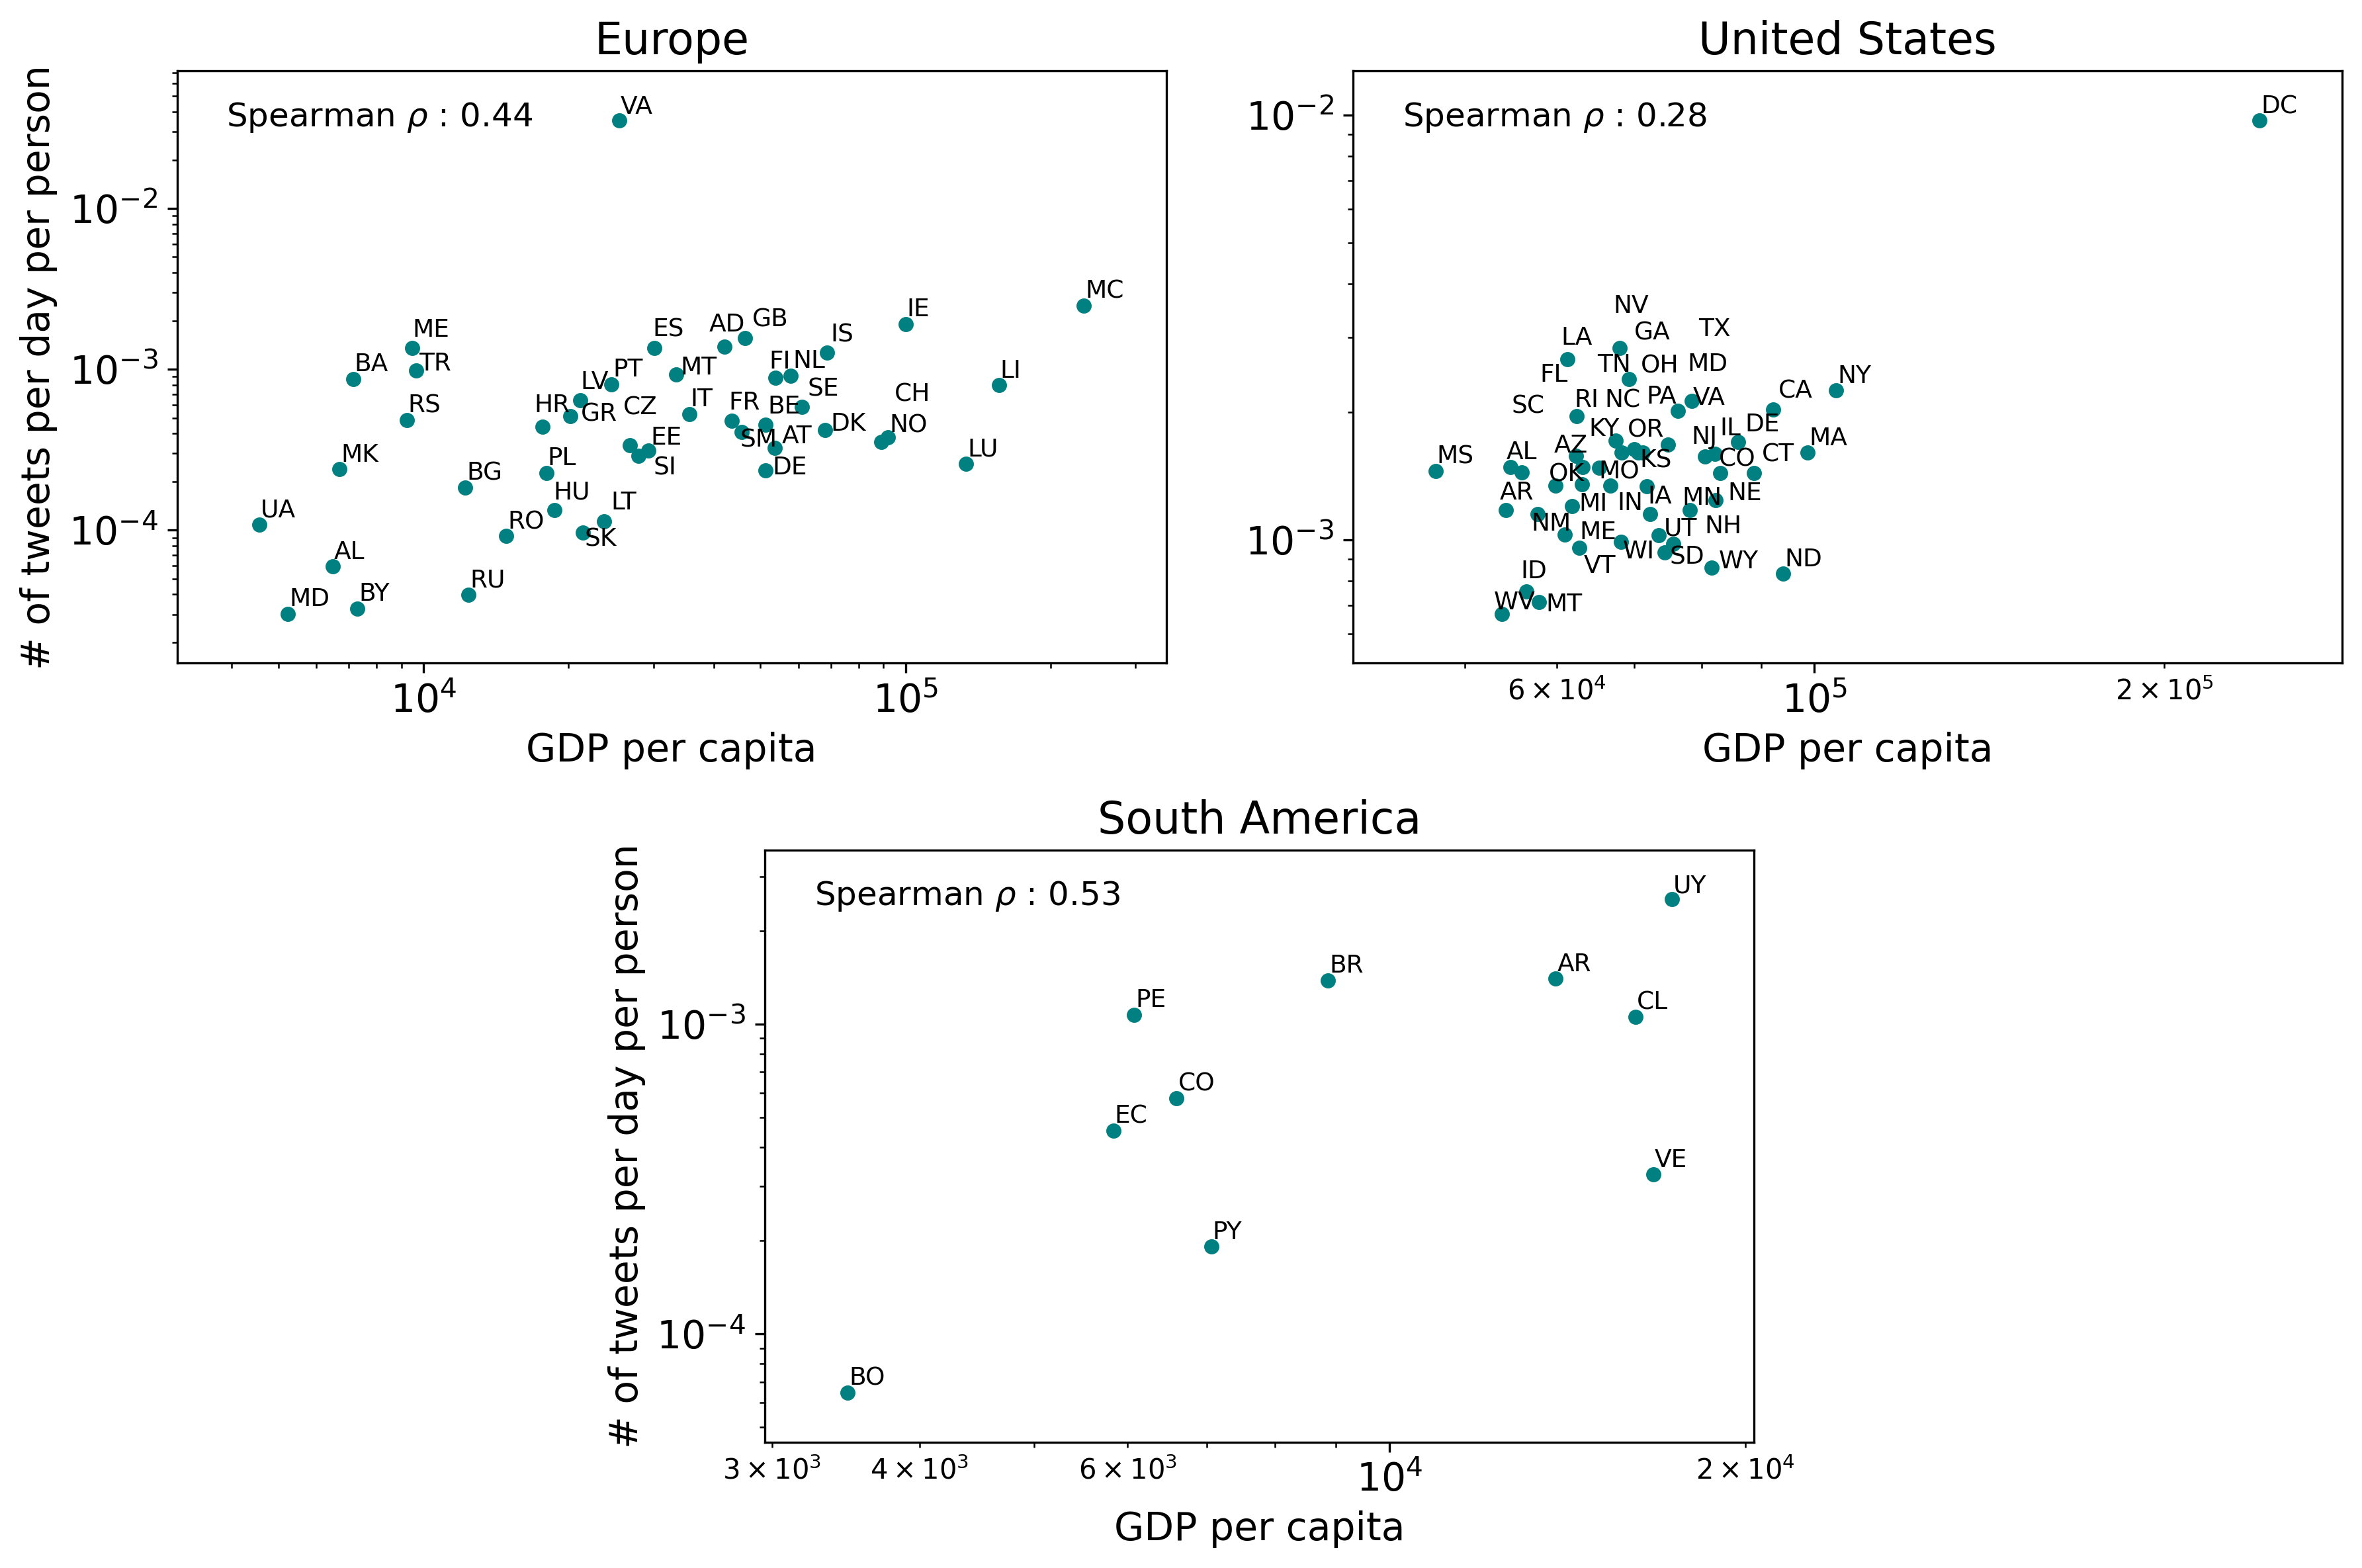

In [43]:
def plot_regression(ax, df, title, color='sandybrown'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]]
    
    # Regression
    x_log = np.log10(df_plot[columns1])
    y_log = np.log10(df_plot[columns2])
    

    # Plot data + fit
    ax.loglog(df_plot[columns1], df_plot[columns2], '.', markersize=9, label='Data', color='teal')

    # Add text labels
    xt = list(df[columns1].values)
    yt = list(df[columns2].values)
    t = list(df['ISO 2'].values)
    texts = [ax.text(xt[i], yt[i], t[i], ha='left', va='bottom', size=9, color='black') for i in range(len(xt))]
    adjust_text(texts, ax=ax)
    

    # Compute correlation coefficients
    res = scipy.stats.spearmanr(x_log, y_log)
    spearman_corr = res.statistic
    p_value = res.pvalue

    corr_text = (
        r"Spearman $\rho$ : " + f"{spearman_corr:.2f}"
    )
    ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top')
    
    # Axis and title
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('GDP per capita', fontsize=14)
    ax.set_ylabel('# of tweets per day per person', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Add padding in log space
    log_x_min, log_x_max = x_log.min(), x_log.max()
    log_y_min, log_y_max = y_log.min(), y_log.max()
    
    padding_factor = 0.1  # 10% padding
    log_x_range = log_x_max - log_x_min
    log_y_range = log_y_max - log_y_min
    
    ax.set_xlim(10**(log_x_min - padding_factor * log_x_range),
                10**(log_x_max + padding_factor * log_x_range))
    ax.set_ylim(10**(log_y_min - padding_factor * log_y_range),
                10**(log_y_max + padding_factor * log_y_range))
    
    print(f"p - value {title} is {p_value}")
    
# Create a figure with a 4-column, 2-row grid layout
fig = plt.figure(figsize=(12, 8), dpi=300)
gs = gridspec.GridSpec(2, 4, figure=fig)

# Assign axes to specific grid locations
ax1 = fig.add_subplot(gs[0, 0:2])  # First row, first two columns
ax2 = fig.add_subplot(gs[0, 2:4])  # First row, last two columns
ax3 = fig.add_subplot(gs[1, 1:3])  # Second row, center two columns

# Generate the plots
plot_regression(ax1, df_eu, 'Europe')
plot_regression(ax2, df_us, 'United States')
plot_regression(ax3, df_sa, 'South America')

# Remove y-axis label from second plot to avoid redundancy
ax2.set_ylabel('')

plt.tight_layout()
fig.savefig('gdp_per_capita_tweets_comparison_spearman.pdf', dpi=300, bbox_inches='tight')
plt.show()

### other analysis

(0.0, 0.005)

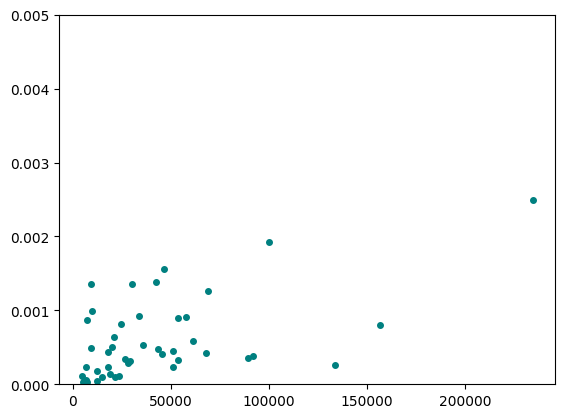

In [9]:
columns1 = 'gdp per capita'
columns2 = 'tweets per day per person'
df_plot = df_eu[[columns1, columns2]]
    
plt.plot(df_plot[columns1],df_plot[columns2], '.', markersize=8, label='Data', color='teal')
plt.ylim(0,0.005)

Europe Spearman correlation: SignificanceResult(statistic=0.44426877470355725, pvalue=0.002233481752524856)
Europe Spearman correlation: SignificanceResult(statistic=0.44426877470355725, pvalue=0.002233481752524856)
United States Spearman correlation: SignificanceResult(statistic=0.28300043421623966, pvalue=0.05128942846667299)
United States Spearman correlation: SignificanceResult(statistic=0.28300043421623966, pvalue=0.05128942846667299)
South America Spearman correlation: SignificanceResult(statistic=0.5272727272727272, pvalue=0.11730806555020223)
South America Spearman correlation: SignificanceResult(statistic=0.5272727272727272, pvalue=0.11730806555020223)


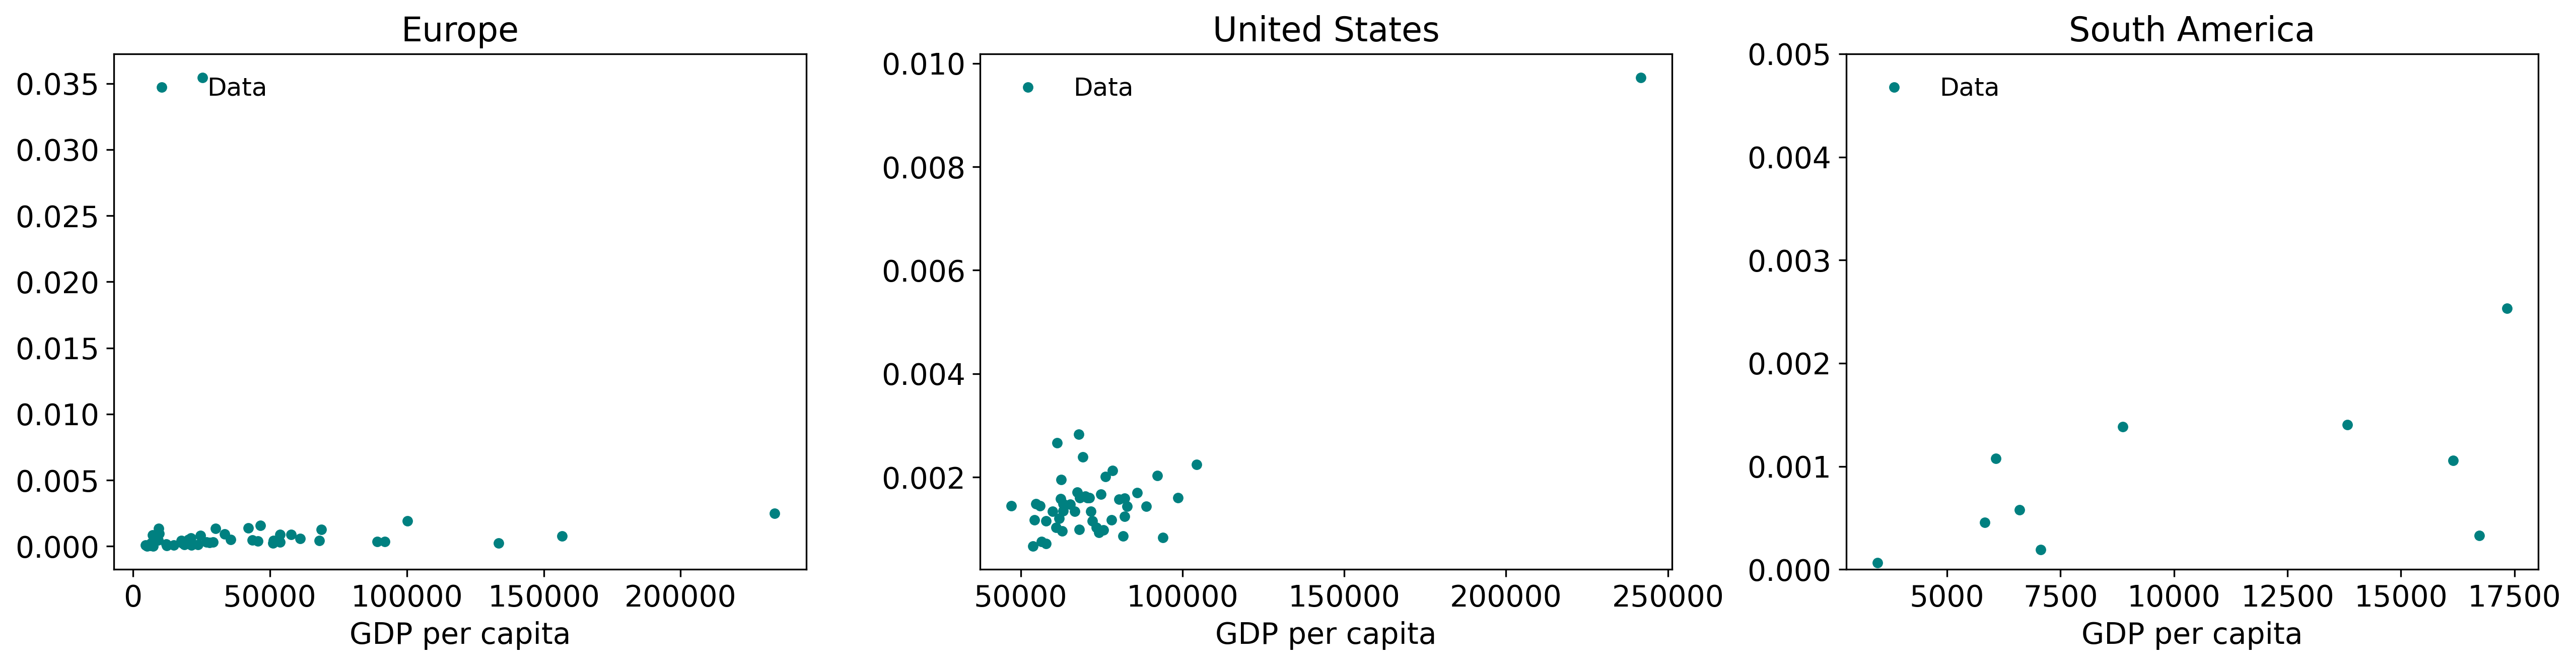

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
#from adjustText import adjust_tex

def plot_linear(ax, df, title, color='sandybrown'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]]
    
    ax.plot(df[columns1], df[columns2], '.', markersize=8, label='Data', color='teal')

    
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('GDP per capita', fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(fontsize=12, loc='upper left', frameon=False)
    plt.ylim(0,0.005)
    
    print(f"{title} Spearman correlation:", scipy.stats.spearmanr(np.log10(df_plot[columns1]), np.log10(df_plot[columns2])))
    print(f"{title} Spearman correlation:", scipy.stats.spearmanr(df_plot[columns1], df_plot[columns2]))
    

# Assuming df1, df2, df3 are your three DataFrames
fig, axes = plt.subplots(1, 3, figsize=(17, 4.5), dpi=300)
plot_linear(axes[0], df_eu, 'Europe')
plot_linear(axes[1], df_us, 'United States')
plot_linear(axes[2], df_sa, 'South America')

# Keep y-axis ticks on all plots, but only show the y-axis label on the leftmost plot
for ax in axes[1:]:
    ax.yaxis.set_tick_params(labelleft=True)  # Ensure ticks are present on the left of second and third subplots
    ax.set_ylabel('')  # Remove y-axis label on the second and third plots

plt.tight_layout()
plt.show()


slope 0.6010786690385219
intercept -6.053004666120151
Europe stats: {'intercept': -6.053004666120151, 'slope': 0.6010786690385219, 'R2': 0.2017710299955352}
Europe Spearman correlation: SignificanceResult(statistic=0.44426877470355725, pvalue=0.002233481752524856)
slope 1.0360062765842222
intercept -7.8714227672873145
United States stats: {'intercept': -7.8714227672873145, 'slope': 1.0360062765842222, 'R2': 0.3527350983986235}
United States Spearman correlation: SignificanceResult(statistic=0.28300043421623966, pvalue=0.05128942846667299)
slope 1.2977080067855078
intercept -8.351216809318482
South America stats: {'intercept': -8.351216809318482, 'slope': 1.2977080067855078, 'R2': 0.4239731800579889}
South America Spearman correlation: SignificanceResult(statistic=0.5272727272727272, pvalue=0.11730806555020223)


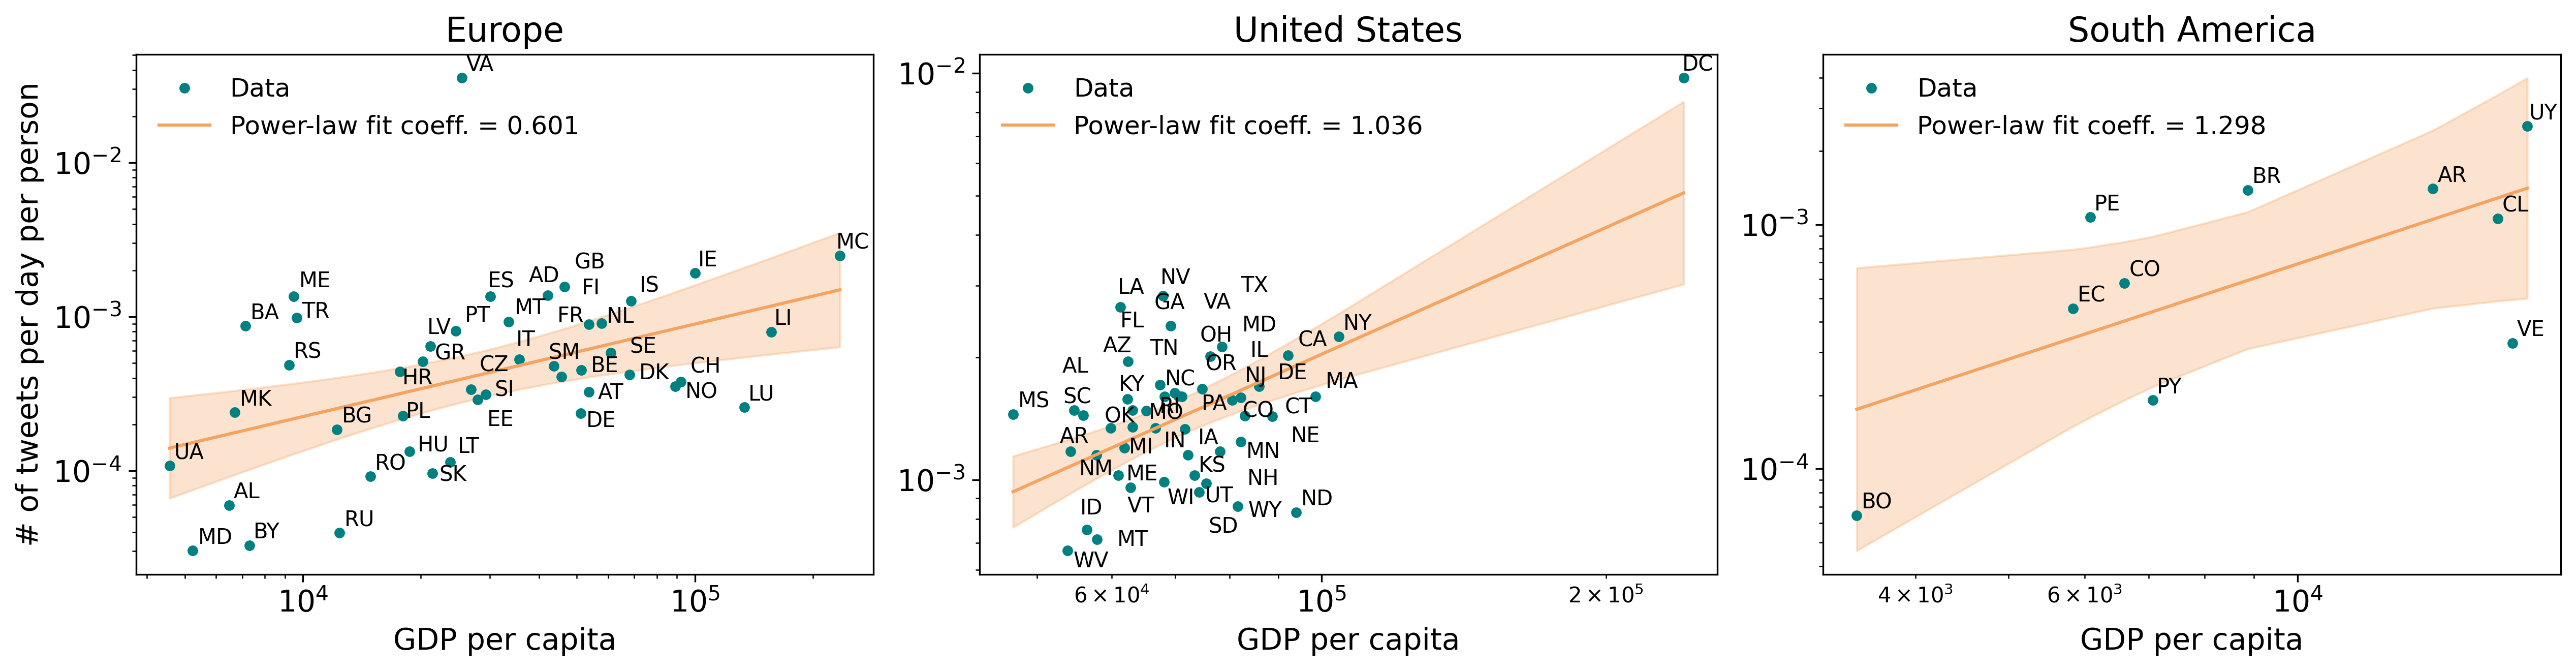

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from adjustText import adjust_text

def plot_regression(ax, df, title, color='sandybrown'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]]
    
    # Regression plot
    x, y, y_fit, y_low, y_high, stats = linear_regplot(np.log10(df_plot[columns1]), np.log10(df_plot[columns2]))
    b, m = stats['intercept'], stats['slope']
    
    ax.loglog(df[columns1], df[columns2], '.', markersize=8, label='Data', color='teal')
    ax.plot(10**x, y_fit, color='sandybrown', label=f'Power-law fit coeff. = {np.round(m,3)}')
    ax.fill_between(10**x, y_low, y_high, color='sandybrown', alpha=0.3, label="_nolegend_")
    
    xt = list(df[columns1].values)
    yt = list(df[columns2].values)
    t = list(df['ISO 2'].values)
    texts = [ax.text(xt[i], yt[i], t[i], ha='left', va='bottom', size=10, color='black') for i in range(len(xt))]
    adjust_text(texts, ax=ax)
    
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('GDP per capita', fontsize=14)
    
    if ax == axes[0]:  # Only set ylabel for the first plot
        ax.set_ylabel('# of tweets per day per person', fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(fontsize=12, loc='upper left', frameon=False)
    
    print(f"{title} stats:", stats)
    print(f"{title} Spearman correlation:", scipy.stats.spearmanr(np.log10(df_plot[columns1]), np.log10(df_plot[columns2])))

# Assuming df1, df2, df3 are your three DataFrames
fig, axes = plt.subplots(1, 3, figsize=(17, 4.5), dpi=300)
plot_regression(axes[0], df_eu, 'Europe')
plot_regression(axes[1], df_us, 'United States')
plot_regression(axes[2], df_sa, 'South America')

# Keep y-axis ticks on all plots, but only show the y-axis label on the leftmost plot
for ax in axes[1:]:
    ax.yaxis.set_tick_params(labelleft=True)  # Ensure ticks are present on the left of second and third subplots
    ax.set_ylabel('')  # Remove y-axis label on the second and third plots

plt.tight_layout()
plt.show()

slope 0.6010786690385219
intercept -6.053004666120151
Europe stats: {'intercept': -6.053004666120151, 'slope': 0.6010786690385219, 'R2': 0.2017710299955352}
Europe Spearman correlation: PearsonRResult(statistic=0.44918930307336485, pvalue=0.001966475722508125)
slope 1.0360062765842222
intercept -7.8714227672873145
United States stats: {'intercept': -7.8714227672873145, 'slope': 1.0360062765842222, 'R2': 0.3527350983986235}
United States Spearman correlation: PearsonRResult(statistic=0.5939150599190283, pvalue=8.591324037667382e-06)
slope 1.2977080067855078
intercept -8.351216809318482
South America stats: {'intercept': -8.351216809318482, 'slope': 1.2977080067855078, 'R2': 0.4239731800579889}
South America Spearman correlation: PearsonRResult(statistic=0.6511322293190441, pvalue=0.041423304776911564)


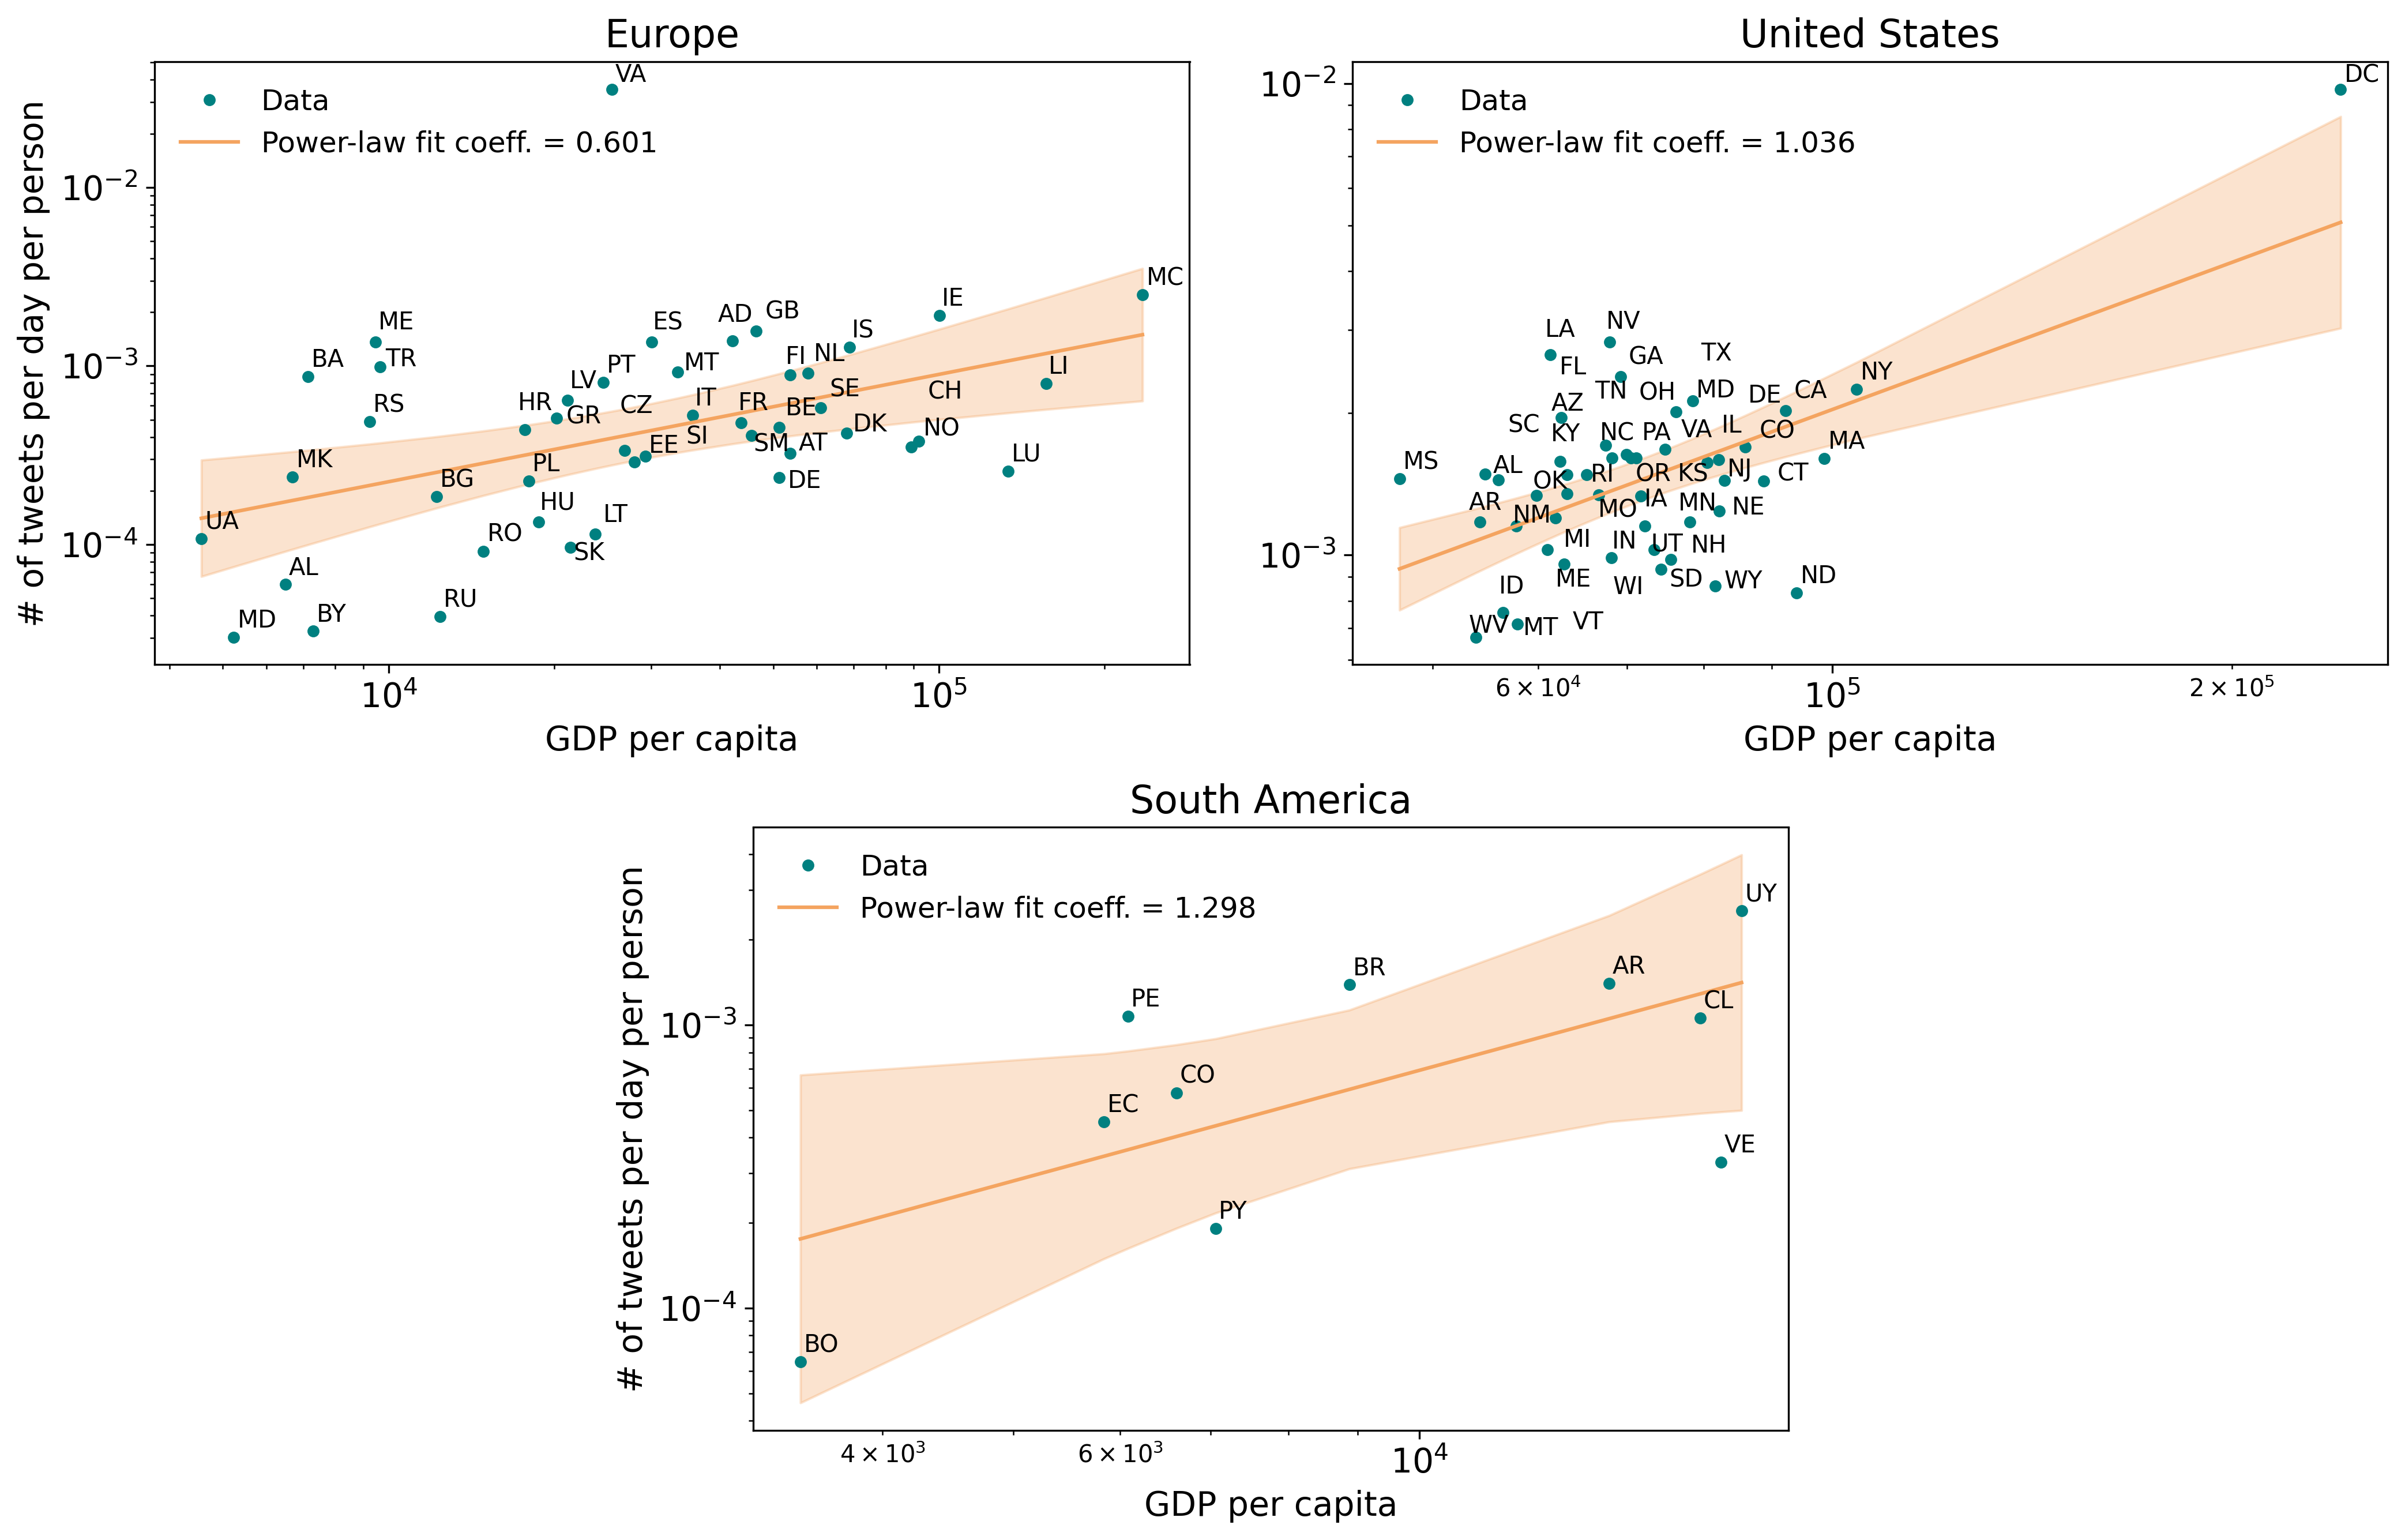

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from adjustText import adjust_text
import matplotlib.gridspec as gridspec

def plot_regression(ax, df, title, color='sandybrown'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]]
    
    # Regression plot
    x, y, y_fit, y_low, y_high, stats = linear_regplot(np.log10(df_plot[columns1]), np.log10(df_plot[columns2]))
    b, m = stats['intercept'], stats['slope']
    
    ax.loglog(df[columns1], df[columns2], '.', markersize=8, label='Data', color='teal')
    ax.plot(10**x, y_fit, color='sandybrown', label=f'Power-law fit coeff. = {np.round(m,3)}')
    ax.fill_between(10**x, y_low, y_high, color='sandybrown', alpha=0.3, label="_nolegend_")
    
    xt = list(df[columns1].values)
    yt = list(df[columns2].values)
    t = list(df['ISO 2'].values)
    texts = [ax.text(xt[i], yt[i], t[i], ha='left', va='bottom', size=10, color='black') for i in range(len(xt))]
    adjust_text(texts, ax=ax)
    
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('GDP per capita', fontsize=14)
    ax.set_ylabel('# of tweets per day per person', fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(fontsize=12, loc='upper left', frameon=False)
    
    print(f"{title} stats:", stats)
    print(f"{title} Spearman correlation:", scipy.stats.pearsonr(np.log10(df_plot[columns1]), np.log10(df_plot[columns2])))

# Create a figure with a 4-column, 2-row grid layout
fig = plt.figure(figsize=(14, 9), dpi=300)
gs = gridspec.GridSpec(2, 4, figure=fig)

# Assign axes to specific grid locations
ax1 = fig.add_subplot(gs[0, 0:2])  # First row, first two columns
ax2 = fig.add_subplot(gs[0, 2:4])  # First row, last two columns
ax3 = fig.add_subplot(gs[1, 1:3])  # Second row, center two columns

# Generate the plots
plot_regression(ax1, df_eu, 'Europe')
plot_regression(ax2, df_us, 'United States')
plot_regression(ax3, df_sa, 'South America')

# Remove y-axis label from second plot to avoid redundancy
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


slope 0.6010786690385219
intercept -6.053004666120151
Europe stats: {'intercept': -6.053004666120151, 'slope': 0.6010786690385219, 'R2': 0.2017710299955352}
Europe Spearman correlation: SignificanceResult(statistic=0.44426877470355725, pvalue=0.002233481752524856)
Europe KS test: stat=0.1004, p=0.7174
slope 1.0360062765842222
intercept -7.8714227672873145
United States stats: {'intercept': -7.8714227672873145, 'slope': 1.0360062765842222, 'R2': 0.3527350983986235}
United States Spearman correlation: SignificanceResult(statistic=0.28300043421623966, pvalue=0.05128942846667299)
United States KS test: stat=0.0779, p=0.9107
slope 1.2977080067855078
intercept -8.351216809318482
South America stats: {'intercept': -8.351216809318482, 'slope': 1.2977080067855078, 'R2': 0.4239731800579889}
South America Spearman correlation: SignificanceResult(statistic=0.5272727272727272, pvalue=0.11730806555020223)
South America KS test: stat=0.2372, p=0.5504


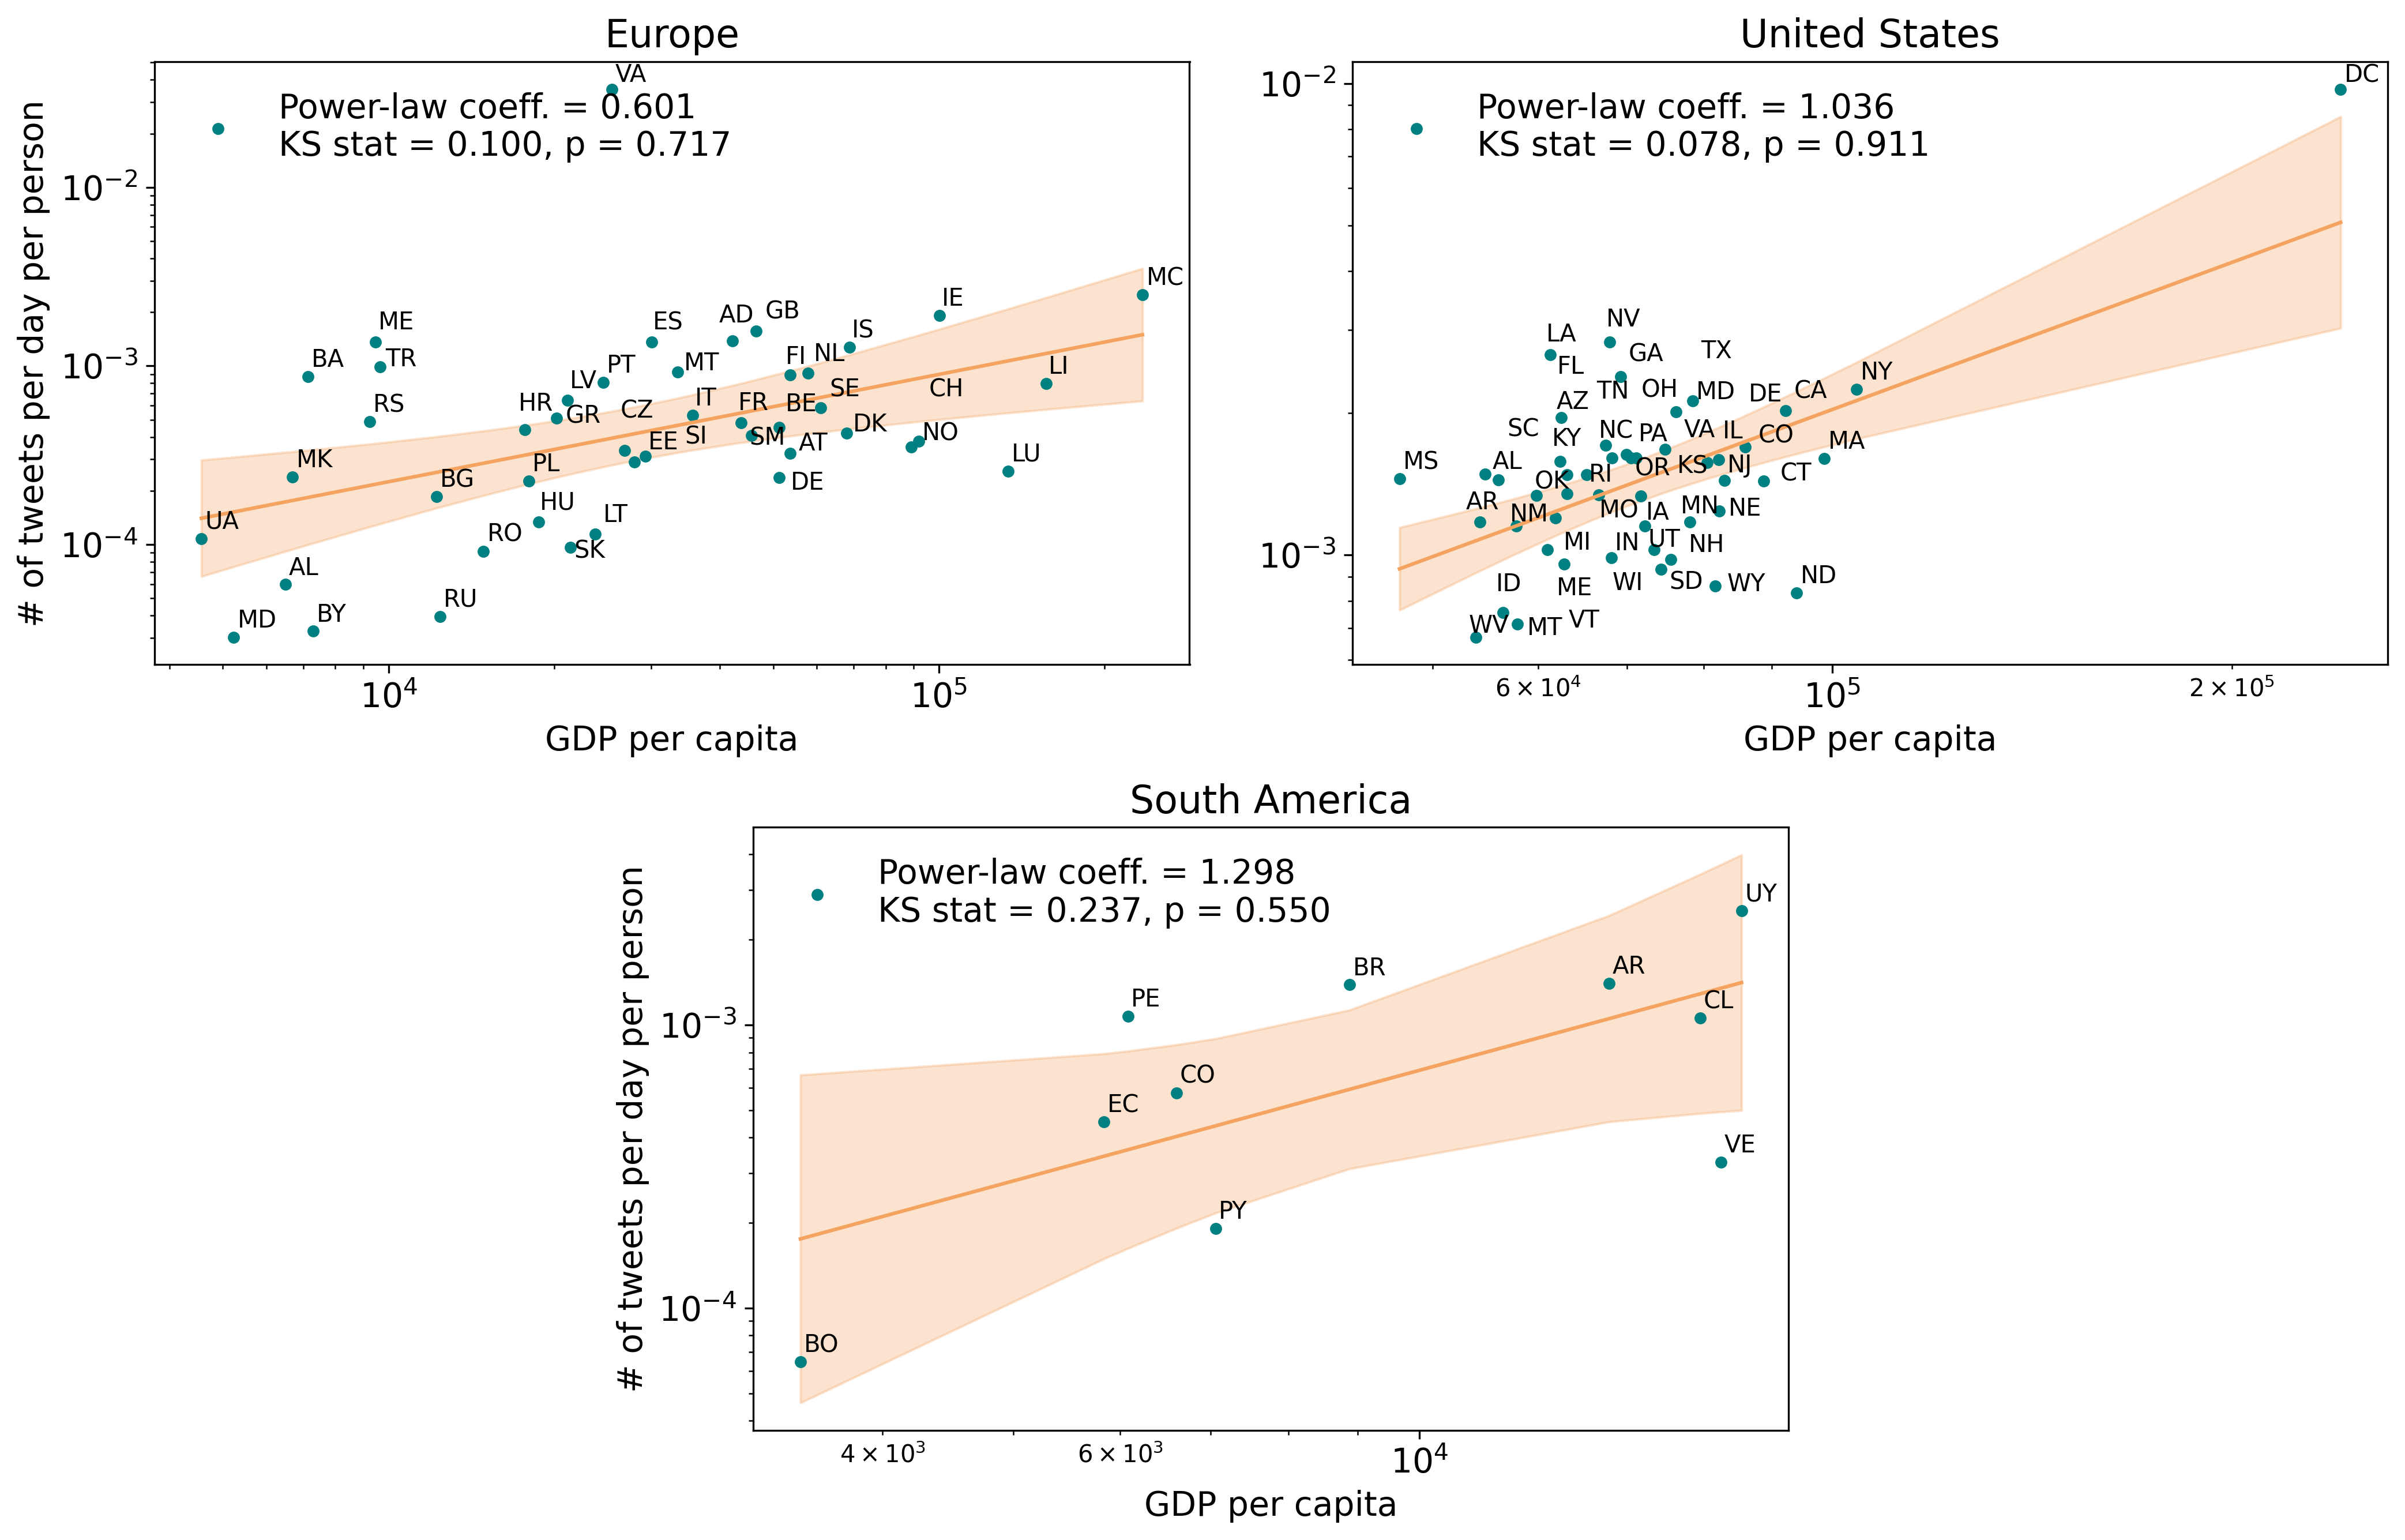

In [13]:
def plot_regression(ax, df, title, color='sandybrown'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]]
    
    # Regression
    x_log = np.log10(df_plot[columns1])
    y_log = np.log10(df_plot[columns2])
    
    # Fit regression line
    x, y, y_fit, y_low, y_high, stats = linear_regplot(x_log, y_log)
    b, m = stats['intercept'], stats['slope']
    
    # Residuals for KS test
    residuals = y_log - (m * x_log + b)
    ks_stat, ks_pval = scipy.stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
    
    # Plot data + fit
    ax.loglog(df_plot[columns1], df_plot[columns2], '.', markersize=8, label='Data', color='teal')
    ax.plot(10**x, y_fit, color=color, label=f'Power-law coeff. = {np.round(m,3)}')
    ax.fill_between(10**x, y_low, y_high, color=color, alpha=0.3, label="_nolegend_")
    
    # Add text labels
    xt = list(df[columns1].values)
    yt = list(df[columns2].values)
    t = list(df['ISO 2'].values)
    texts = [ax.text(xt[i], yt[i], t[i], ha='left', va='bottom', size=10, color='black') for i in range(len(xt))]
    adjust_text(texts, ax=ax)
    
    # Axis and title
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('GDP per capita', fontsize=14)
    ax.set_ylabel('# of tweets per day per person', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Legend
    legend_text = (f'Power-law coeff. = {np.round(m,3)}\n'
                   f'KS stat = {ks_stat:.3f}, p = {ks_pval:.3f}')
    ax.legend([legend_text], fontsize=14, loc='upper left', frameon=False)
    
    # Print stats
    print(f"{title} stats:", stats)
    print(f"{title} Spearman correlation:", scipy.stats.spearmanr(x_log, y_log))
    print(f"{title} KS test: stat={ks_stat:.4f}, p={ks_pval:.4f}")

# Create a figure with a 4-column, 2-row grid layout
fig = plt.figure(figsize=(14, 9), dpi=300)
gs = gridspec.GridSpec(2, 4, figure=fig)

# Assign axes to specific grid locations
ax1 = fig.add_subplot(gs[0, 0:2])  # First row, first two columns
ax2 = fig.add_subplot(gs[0, 2:4])  # First row, last two columns
ax3 = fig.add_subplot(gs[1, 1:3])  # Second row, center two columns

# Generate the plots
plot_regression(ax1, df_eu, 'Europe')
plot_regression(ax2, df_us, 'United States')
plot_regression(ax3, df_sa, 'South America')

# Remove y-axis label from second plot to avoid redundancy
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
def plot_rank_scatter(ax, df, title, color='teal'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]].copy()

    # Compute ranks
    df_plot['x_rank'] = df_plot[columns1].rank()
    df_plot['y_rank'] = df_plot[columns2].rank()

    x_rank = df_plot['x_rank']
    y_rank = df_plot['y_rank']

    # Scatter plot of ranks
    ax.plot(x_rank, y_rank, '.', markersize=9, label='Data', color=color)

    # Add text labels
    xt = list(x_rank.values)
    yt = list(y_rank.values)
    t = list(df['ISO 2'].values)
    texts = [ax.text(xt[i], yt[i], t[i], ha='left', va='bottom', size=9, color='black') for i in range(len(xt))]
    adjust_text(texts, ax=ax)

    # Compute correlation coefficients
    res = scipy.stats.spearmanr(df[columns1], df[columns2])
    spearman_corr = res.statistic
    p_value = res.pvalue

    corr_text = (
        r"Spearman $\rho$ : " + f"{spearman_corr:.2f}"
    )
    #ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
    #        fontsize=12, verticalalignment='top')

    # Axis and title
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('Rank GDP per capita', fontsize=14)
    ax.set_ylabel('Rank tweets per day per person', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Add padding to x and y axes
    padding_x = 4
    padding_y = 4
    ax.set_xlim(x_rank.min() - x_rank.max()*0.15, x_rank.max() + x_rank.max()*0.15)
    ax.set_ylim(y_rank.min() - y_rank.max()*0.15, y_rank.max() + y_rank.max()*0.15)

    print(f"p - value {title} is {p_value}")


p - value Europe is 0.002233481752524856
p - value United States is 0.05128942846667299
p - value South America is 0.11730806555020223


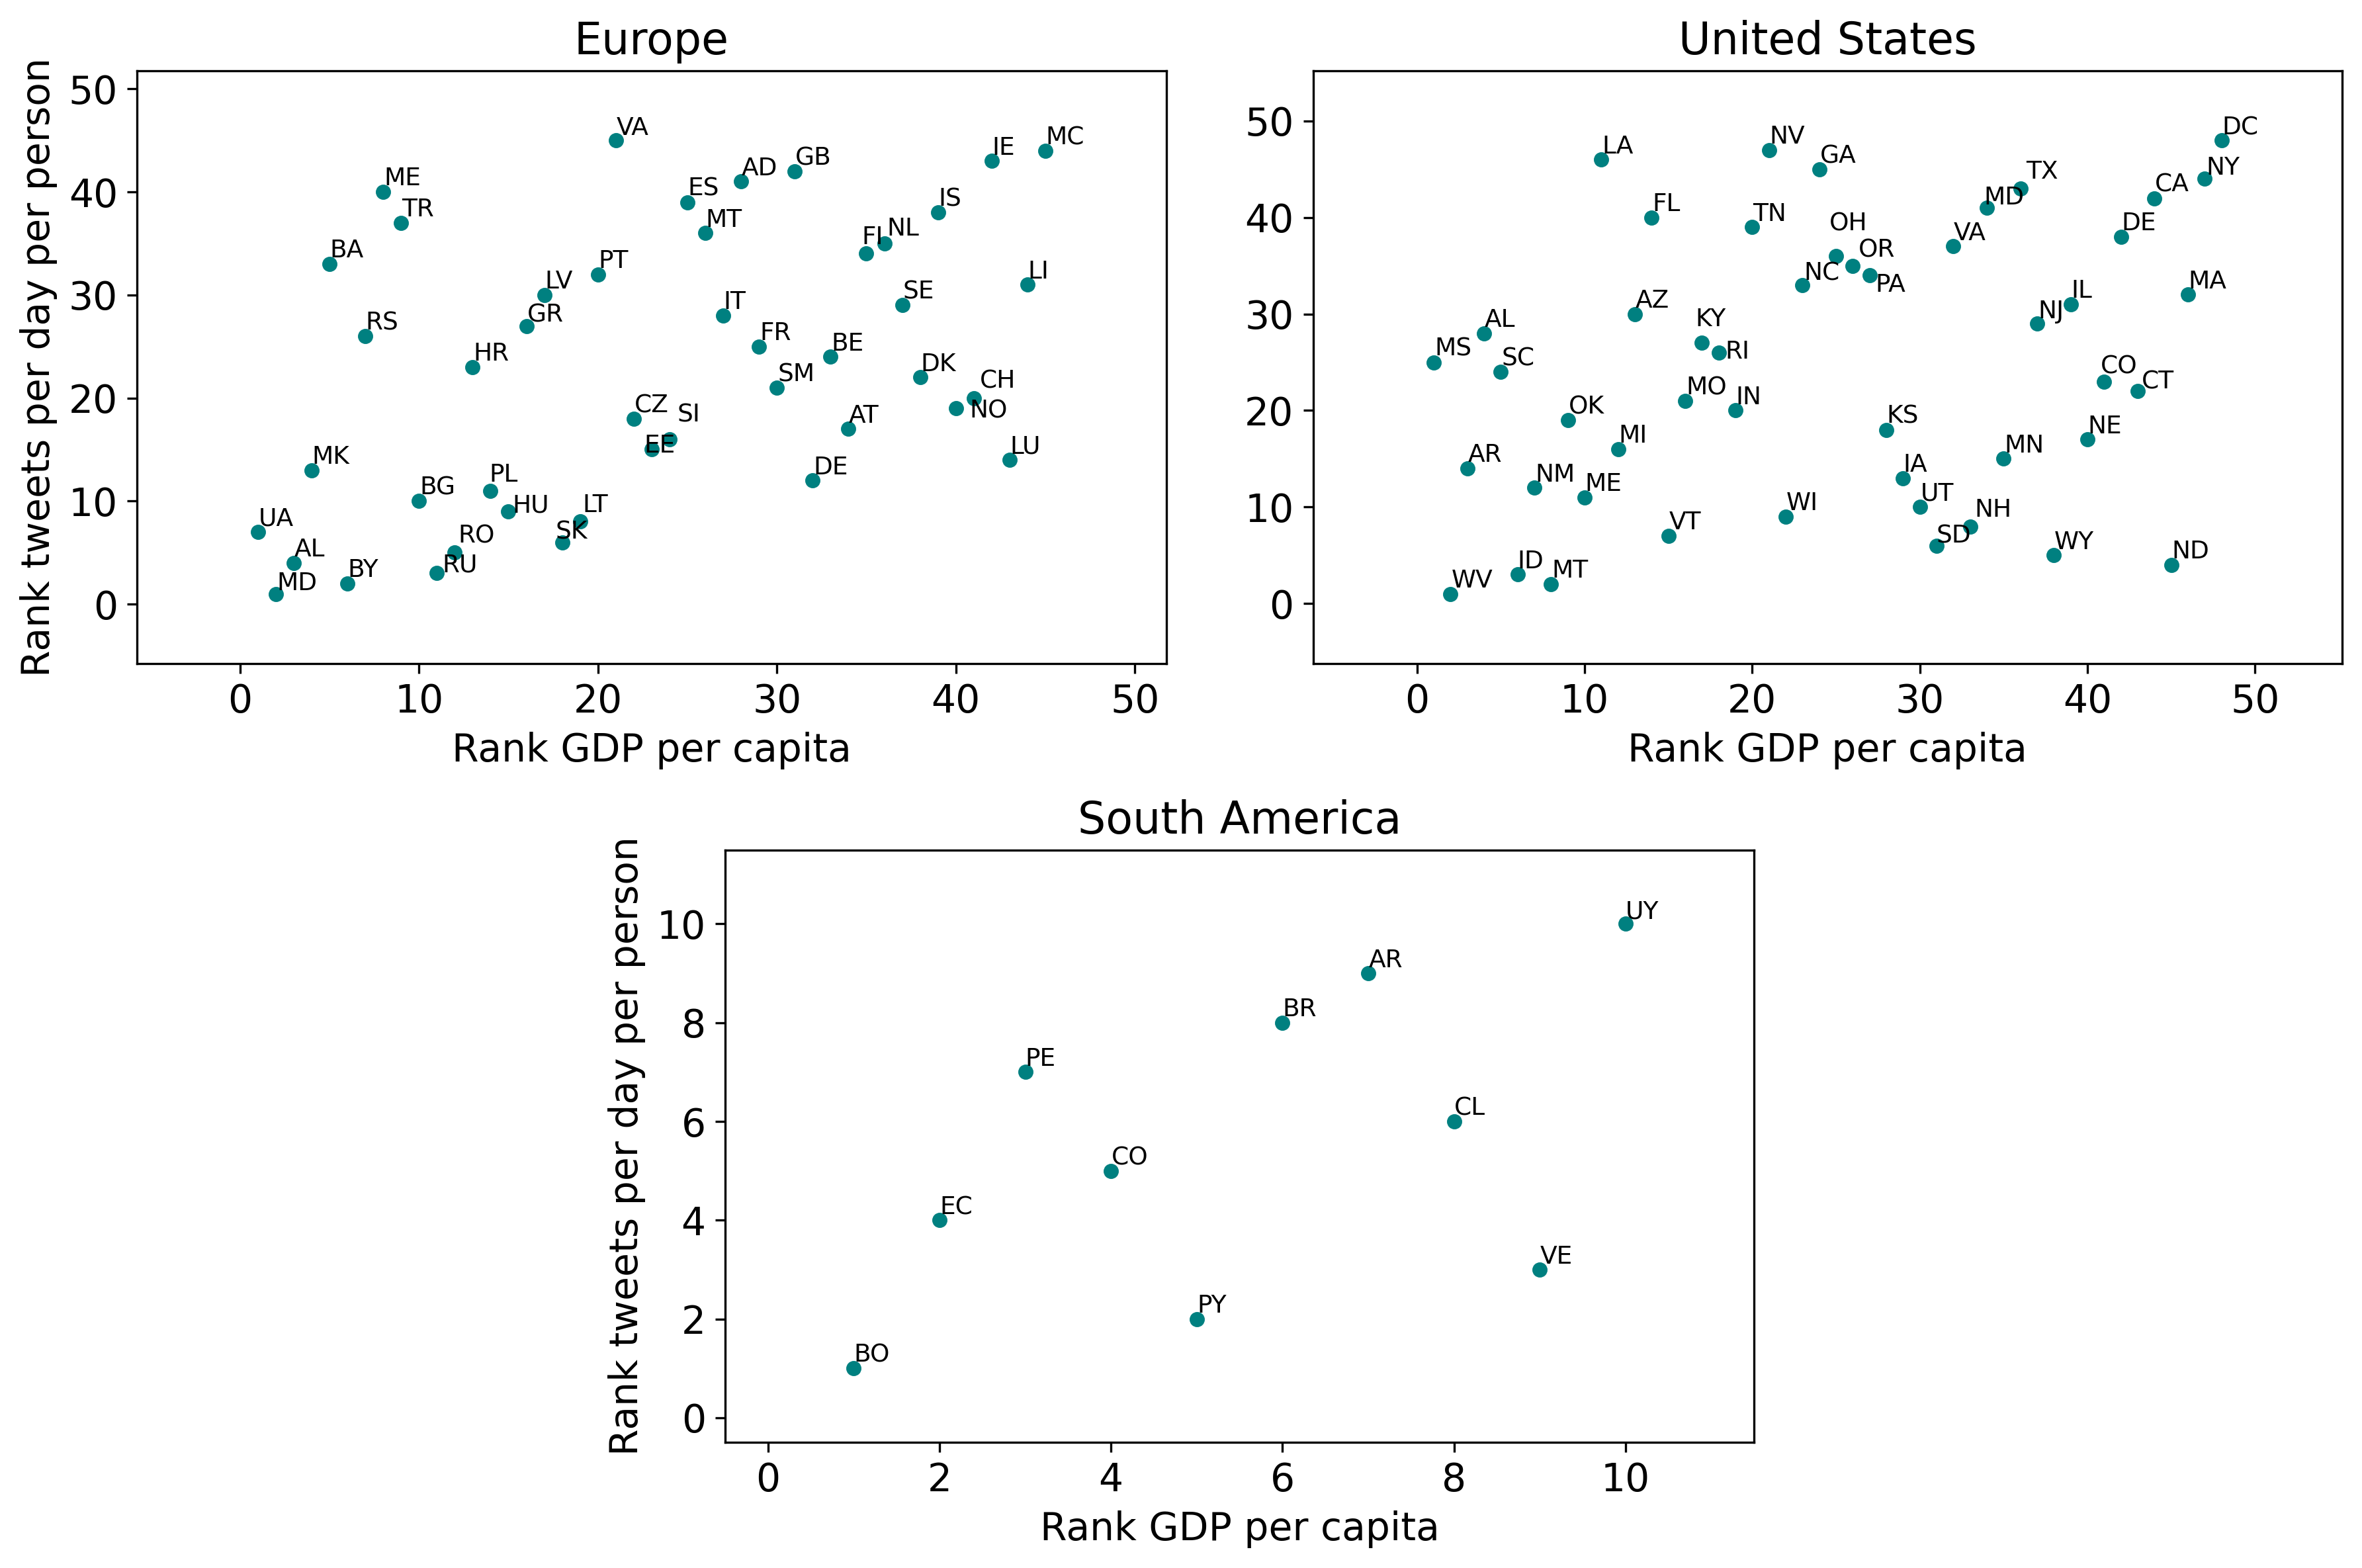

In [26]:
# Create a figure with a 4-column, 2-row grid layout
fig = plt.figure(figsize=(12, 8), dpi=300)
gs = gridspec.GridSpec(2, 4, figure=fig)

# Assign axes to specific grid locations
ax1 = fig.add_subplot(gs[0, 0:2])  # First row, first two columns
ax2 = fig.add_subplot(gs[0, 2:4])  # First row, last two columns
ax3 = fig.add_subplot(gs[1, 1:3])  # Second row, center two columns

# Generate the rank-based scatter plots
plot_rank_scatter(ax1, df_eu, 'Europe')
plot_rank_scatter(ax2, df_us, 'United States')
plot_rank_scatter(ax3, df_sa, 'South America')

# Remove y-axis label from second plot to avoid redundancy
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from adjustText import adjust_text

def plot_value_vs_rank(ax, df, x_col, y_col, title, color='teal'):
    x = df[x_col]
    x_rank = scipy.stats.rankdata(x)
    ax.plot(x, x_rank, '.', color=color)
    ax.set_xlabel(x_col, fontsize=12)
    ax.set_ylabel(f"Rank of {x_col}", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)

def plot_rank_vs_rank(ax, df, x_col, y_col, title, color='teal'):
    # Compute ranks
    x_rank = scipy.stats.rankdata(df[x_col])
    y_rank = scipy.stats.rankdata(df[y_col])
    
    # Scatter plot of ranks
    ax.plot(x_rank, y_rank, '.', color=color)
    ax.set_xlabel(f"Rank of {x_col}", fontsize=12)
    ax.set_ylabel(f"Rank of {y_col}", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Compute Pearson correlation between ranks
    pearson_corr, p_value = scipy.stats.pearsonr(x_rank, y_rank)
    
    # Add text box with correlation info
    corr_text = (
        r"Pearson $r$ : " + f"{pearson_corr:.2f}"
    )
    #ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
    #        fontsize=11, verticalalignment='top')

# Example usage
x_col = 'gdp per capita'
y_col = 'tweets per day per person'


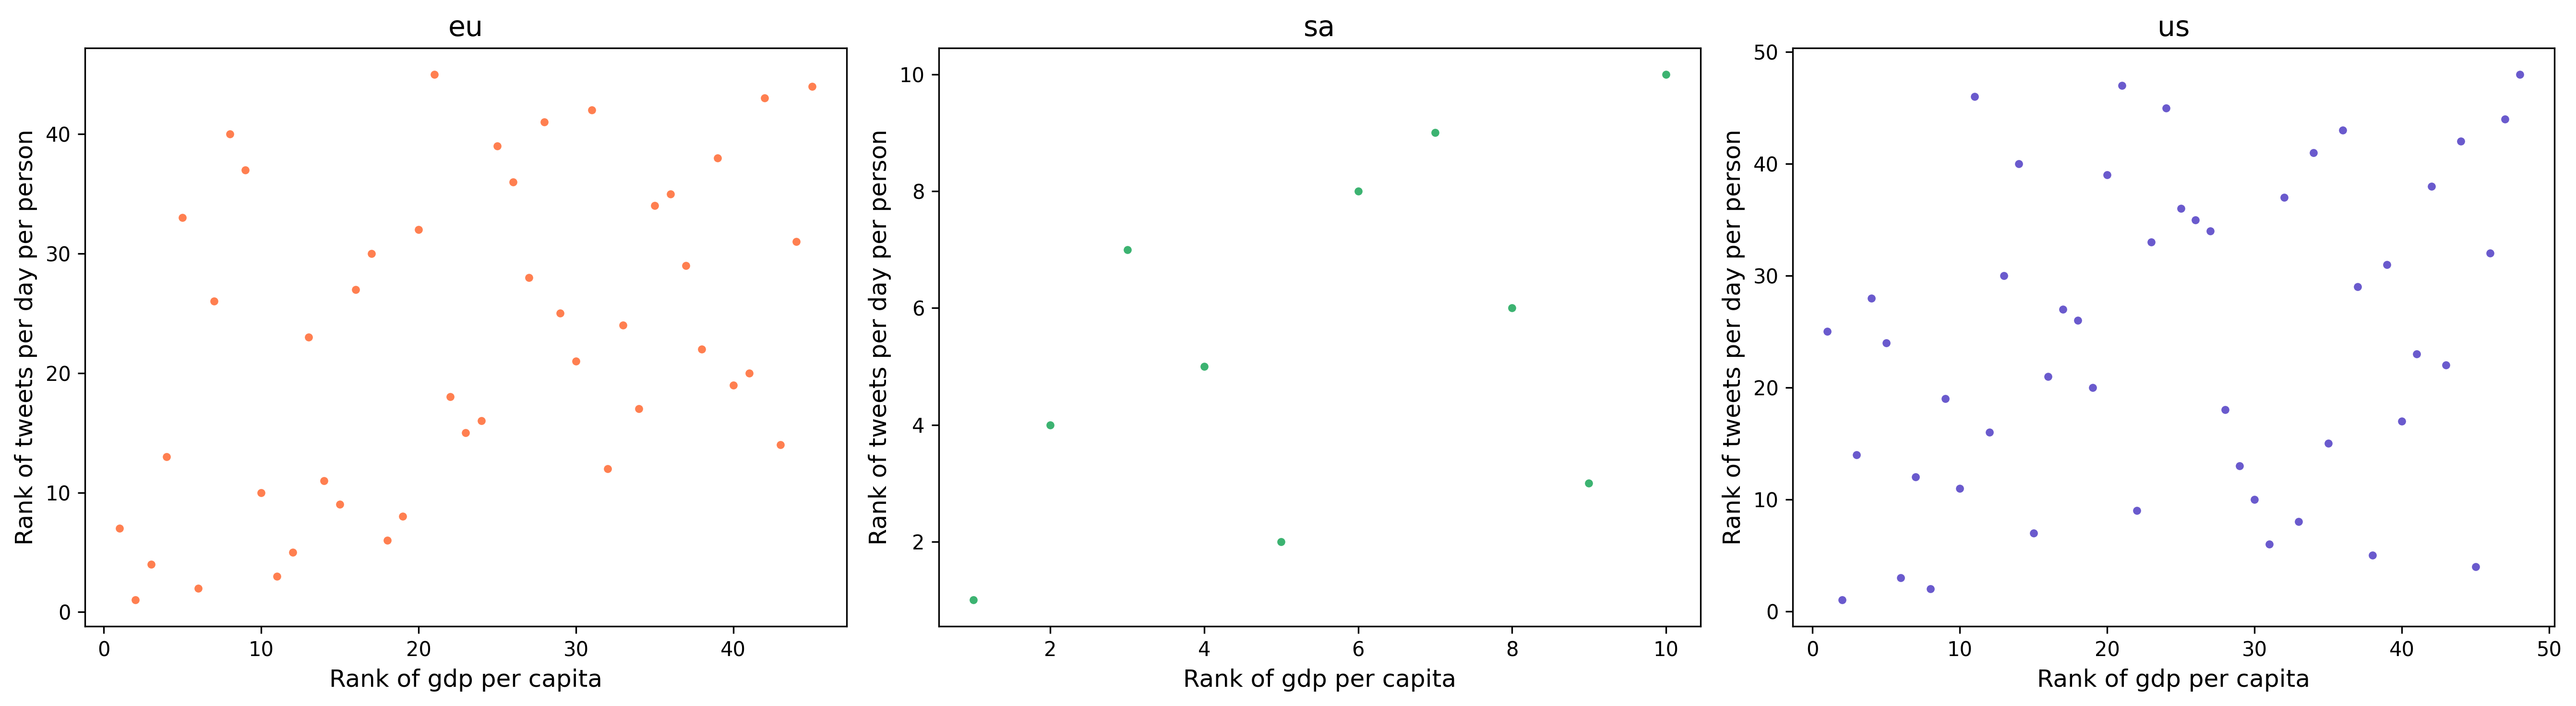

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

plot_rank_vs_rank(axes[0], df_eu, x_col, y_col, 'eu', color='coral')
plot_rank_vs_rank(axes[1], df_sa, x_col, y_col, 'sa', color='mediumseagreen')
plot_rank_vs_rank(axes[2], df_us, x_col, y_col, 'us', color='slateblue')

plt.tight_layout()
plt.show()

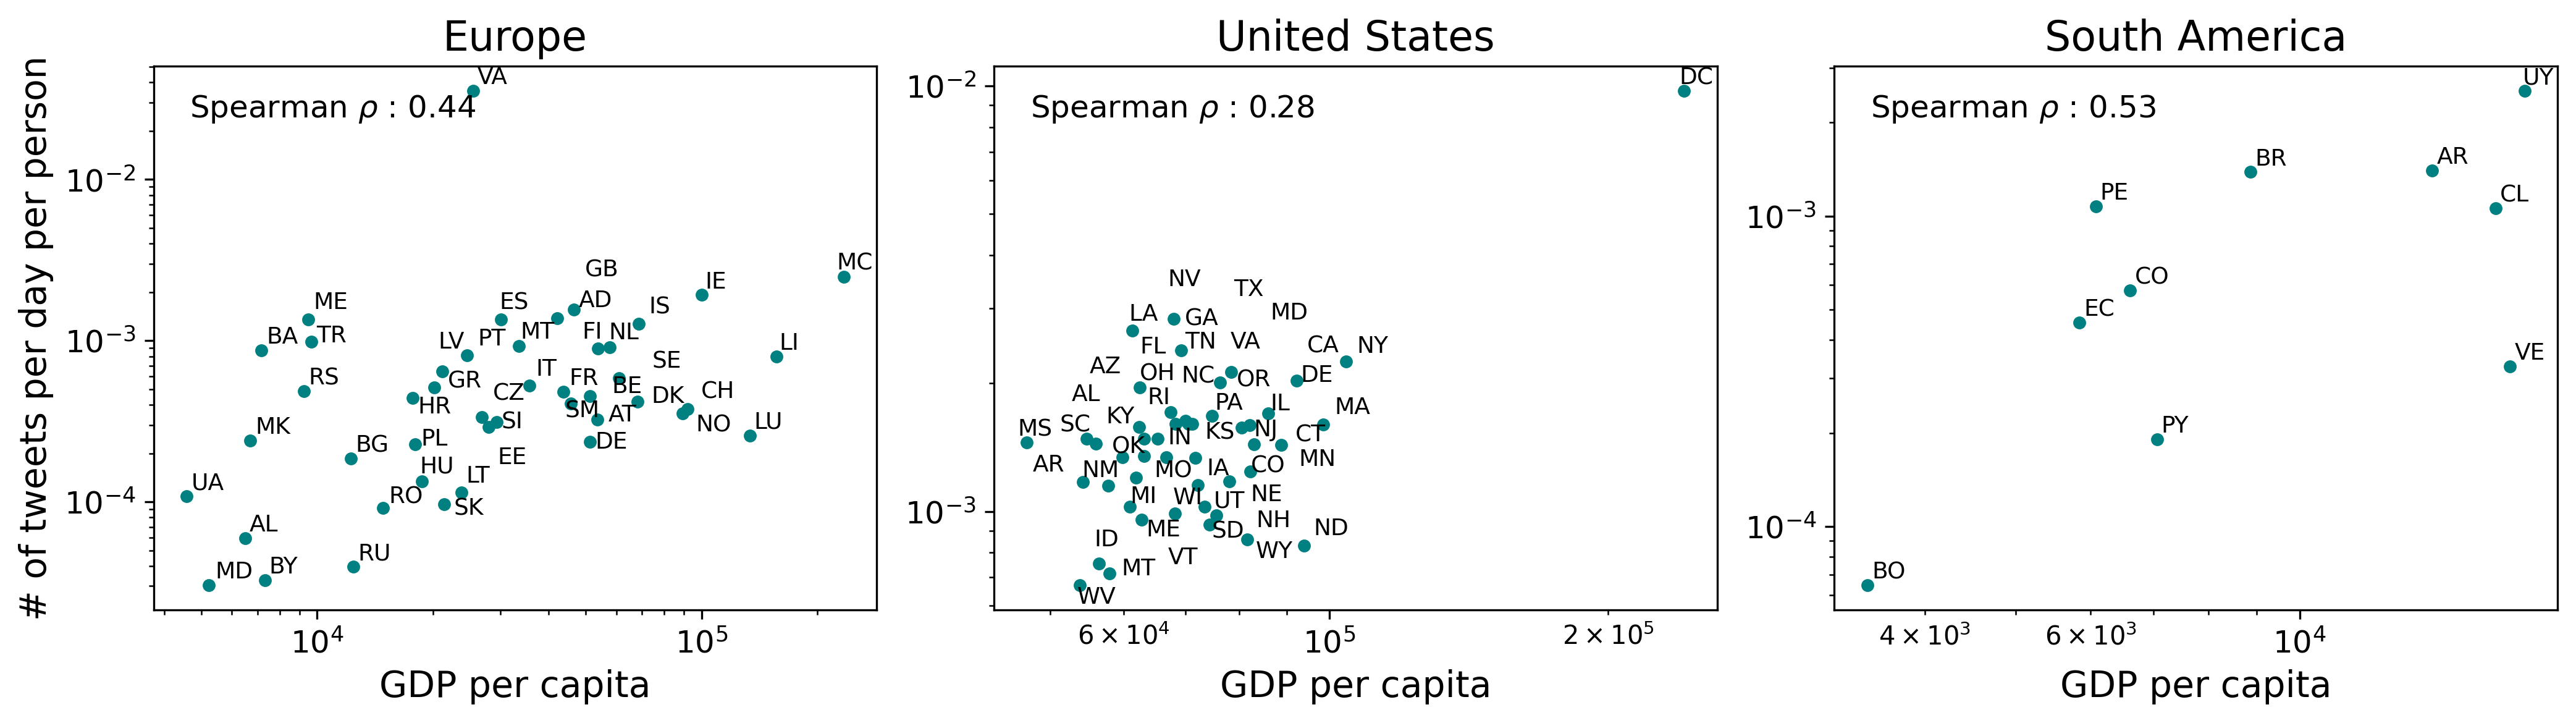

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from adjustText import adjust_text

def plot_regression(ax, df, title, color='teal'):
    columns1 = 'gdp per capita'
    columns2 = 'tweets per day per person'
    df_plot = df[[columns1, columns2]].copy()

    # Filter for positive values to allow log10 safely
    df_plot = df_plot[(df_plot[columns1] > 0) & (df_plot[columns2] > 0)]

    x = df_plot[columns1].values
    y = df_plot[columns2].values


    # Log-log scatter plot
    ax.loglog(x, y, '.', markersize=8, label='Data', color=color)

    # Compute correlation coefficients
    spearman_corr = scipy.stats.spearmanr(x, y)[0]

    #)
    corr_text = (
        r"Spearman $\rho$ : " + f"{spearman_corr:.2f}"
    )
    ax.text(0.05, 0.95, corr_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top')

    # Correlation text in plot
    #corr_text = (
    #    f"Pearson: {pearson_corr:.2f} (lin), {log_pearson_corr:.2f} (log)\n"
    #    f"Spearman: {spearman_corr:.2f} (lin), {log_spearman_corr:.2f} (log)"
    #)

    # Country codes as labels
    xt = df_plot[columns1].values
    yt = df_plot[columns2].values
    t = df.loc[df_plot.index, 'ISO 2'].values  # ensure matching indices
    texts = [ax.text(xt[i], yt[i], t[i], ha='left', va='bottom', size=9, color='black') for i in range(len(xt))]
    adjust_text(texts, ax=ax)

    # Axis labels and title
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('GDP per capita', fontsize=14)
    if ax == axes[0]:
        ax.set_ylabel('# of tweets per day per person', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(14, 4.0), dpi=300)
plot_regression(axes[0], df_eu, 'Europe')
plot_regression(axes[1], df_us, 'United States')
plot_regression(axes[2], df_sa, 'South America')

# Remove y-axis labels on the second and third plots
for ax in axes[1:]:
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


In [31]:
columns1 = 'gdp per capita'
columns2 = 'tweets per day per person'
df_plot = df_us[[columns1, columns2]].copy()

# Filter for positive values to allow log10 safely
df_plot = df_plot[(df_plot[columns1] > 0) & (df_plot[columns2] > 0)]

x = df_plot[columns1].values
y = df_plot[columns2].values

Estimated a (MLE): 1.3447619451960626e-08
Estimated b (MLE): 1.035992232945671
KS statistic: 0.07792091953419772
KS p-value: 0.9107107782444137


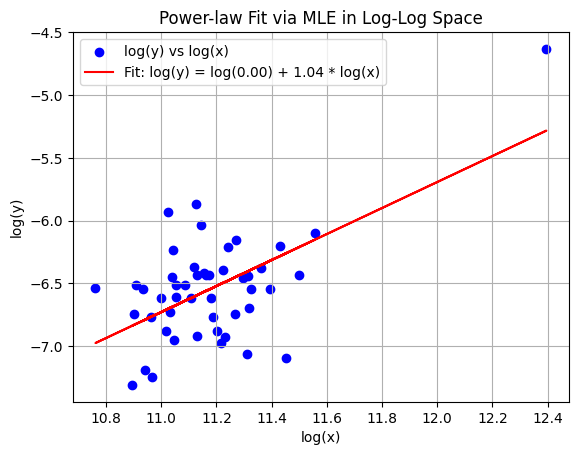

In [32]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import kstest
import matplotlib.pyplot as plt

# Filter positive values (MLE for log only works for y > 0 and x > 0)
mask = (x > 0) & (y > 0)
x = x[mask]
y = y[mask]

# Log-transform
log_x = np.log(x)
log_y = np.log(y)

# --- MLE estimation of the exponent b in y = a * x^b ---
# We model: log(y) = log(a) + b * log(x), so fit b and a via MLE
def neg_log_likelihood(params):
    a_log, b = params
    y_pred = a_log + b * log_x
    residuals = log_y - y_pred
    # Assume Gaussian noise on log-log scale
    return 0.5 * np.sum(residuals**2)

# Initial guess: log(a) = 0, b = 1
res = minimize(neg_log_likelihood, x0=[0.0, 1.0])
a_log_mle, b_mle = res.x
a_mle = np.exp(a_log_mle)

print(f"Estimated a (MLE): {a_mle}")
print(f"Estimated b (MLE): {b_mle}")

# --- Kolmogorov-Smirnov (KS) Test ---
# Under H0: log(y) ~ N(log(a x^b), sigma^2)
log_y_pred = a_log_mle + b_mle * log_x
residuals = log_y - log_y_pred
ks_stat, ks_p = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))

print(f"KS statistic: {ks_stat}")
print(f"KS p-value: {ks_p}")

# --- Plot in log-log scale ---
plt.scatter(log_x, log_y, label='log(y) vs log(x)', color='blue')
plt.plot(log_x, log_y_pred, color='red', label=f'Fit: log(y) = log({a_mle:.2f}) + {b_mle:.2f} * log(x)')
plt.xlabel("log(x)")
plt.ylabel("log(y)")
plt.title("Power-law Fit via MLE in Log-Log Space")
plt.legend()
plt.grid(True)
plt.show()
